# Reconstruction Analysis True Hits (RATH) : Analysis 
- Analysis of the output of the Reconstruction Analysis for True hits (RATH).
- Loads from disk
- Plot Statistics
- GraphTracks manipulation
    - GraphTracks are constructed from the EventTrack object, and are used to define blobs and find blob energy. 
- Visualisation of events where single and multiple tracks where reconstructed in $\beta\beta0\nu$ events.

## Voxel bin = 10, contiguity =15

##### General

In [840]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [841]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [842]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [843]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [844]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

##### IC

In [845]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


##### TICs

In [184]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.graphics_reco import sphere
from tics.system_of_units import *

##### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [11]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import GTracks
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy


In [12]:
from nextflex.io import write_event_gtracks_json
from nextflex.io import load_event_gtracks_json
from nextflex.io import save_to_JSON
from nextflex.io import load_from_JSON

In [13]:
from nextflex.reco_analysis import reco_gtrack_from_mc_hits
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity
from nextflex.reco_analysis import tExtrema_df
from nextflex.reco_analysis import RecoGtrackFromMcHits

In [14]:
from nextflex.analysis_histos import reco_gtrack_stats_histos
from nextflex.analysis_histos import reco_gtrack_timing_histos
from nextflex.analysis_histos import reco_gtrack_blobs_histos
from nextflex.analysis_histos import plot_complexity
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

In [15]:
from nextflex.types import EventHits
from nextflex.types import VoxelHits


In [378]:
from nextflex.analysis_blobs import blob_energy
from nextflex.analysis_blobs import select_topology_and_energy
from nextflex.analysis_blobs import select_blobs_eff_energy
from nextflex.analysis_blobs import select_blobs
from nextflex.analysis_blobs import energy_resolution
from nextflex.analysis_blobs import selection_efficiency
from nextflex.analysis_blobs import distance_reco_true
from nextflex.analysis_blobs import d12_eff

from nextflex.analysis_blobs import select_distance_cut
from nextflex.analysis_blobs import select_energy
from nextflex.analysis_blobs import select_energy
from nextflex.analysis_blobs import select_two_blobs
from nextflex.analysis_blobs import BAD

In [409]:
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

In [709]:
from nextflex.analysis_interactive import single_track_interactive_analysis
from nextflex.analysis_interactive import draw_blobs_energy_and_distances
from nextflex.analysis_interactive import blobs_figure_of_merit
from nextflex.analysis_interactive import blob_selection_efficiency
from nextflex.analysis_interactive import emin_emax
from nextflex.analysis_interactive import draw_blobs_energy
from nextflex.analysis_interactive import draw_blobs_distances
from nextflex.analysis_interactive import rblob_optimisation
from nextflex.analysis_interactive import plot_figures_of_merit

## Input data

In [18]:
FDATA = os.environ['FLEXDATA']

##### bb0nu

In [19]:
setbb = Setup(flexDATA = FDATA,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 621
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

##### single electrons

In [20]:
set1e = Setup(flexDATA = FDATA,
              tpConfig = "FLEX100_M6_O6.EL8bar.1e")
print(set1e)


        Setup <FLEX100_M6_O6.EL8bar.1e_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.1e
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6.EL8bar.1e
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6.EL8bar.1e
        number of h5 files in dir    = 613
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6.EL8bar.1e_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv
        


## Analysis

In [846]:
voxel_bin  = 10
contiguity = 15

### Create a new instance and load from disk

In [847]:
rbb = RecoGtrackFromMcHits(setbb, voxel_bin, contiguity)
rbb.load_setup()

In [848]:
r1e = RecoGtrackFromMcHits(set1e, voxel_bin, contiguity)
r1e.load_setup()

### Statistics

#### Reco Event Statistics

##### bb

In [849]:
rbb.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 10
        contiguity parameter        = 15
        topology                    = all
        event type                  = bb0nu
        voxels from hits barycenter = True
        number of files analyzed    = 620
        number of events analyized  = 2668
        number of events 1 GT       = 1850
        

##### 1e

In [850]:
r1e.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 10
        contiguity parameter        = 15
        topology                    = all
        event type                  = 1e
        voxels from hits barycenter = True
        number of files analyzed    = 612
        number of events analyized  = 2492
        number of events 1 GT       = 1727
        

In [851]:
total_events_bb = rbb.trackRecoEventStats.e_total
total_events_1e = r1e.trackRecoEventStats.e_total
single_track_bb = rbb.trackRecoEventStats.e_gt
single_track_1e = r1e.trackRecoEventStats.e_gt
single_track_eff_bb = single_track_bb / total_events_bb
single_track_eff_1e = single_track_1e / total_events_1e

print(f"""
total events bb = {total_events_bb}, total events 1e = {total_events_1e}
single track bb = {single_track_bb}, single track 1e = {single_track_1e}
single track eff bb = {single_track_eff_bb:5.2f} 
single track eff 1e = {single_track_eff_1e:5.2f}
""")


total events bb = 2668, total events 1e = 2492
single track bb = 1850, single track 1e = 1727
single track eff bb =  0.69 
single track eff 1e =  0.69



#### Complexity

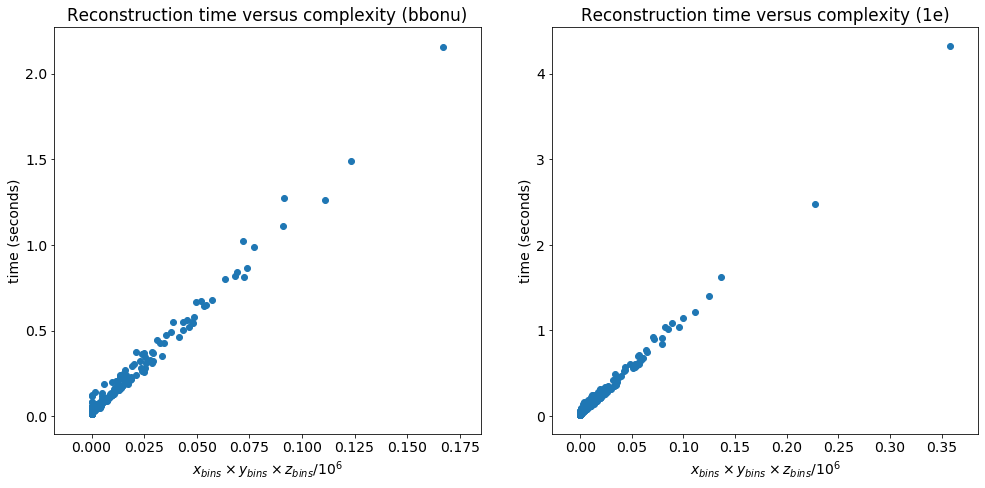

In [852]:
plot_complexity(rbb, r1e, figsize=(14,7))

#### Reco GTracks

##### bb0nu

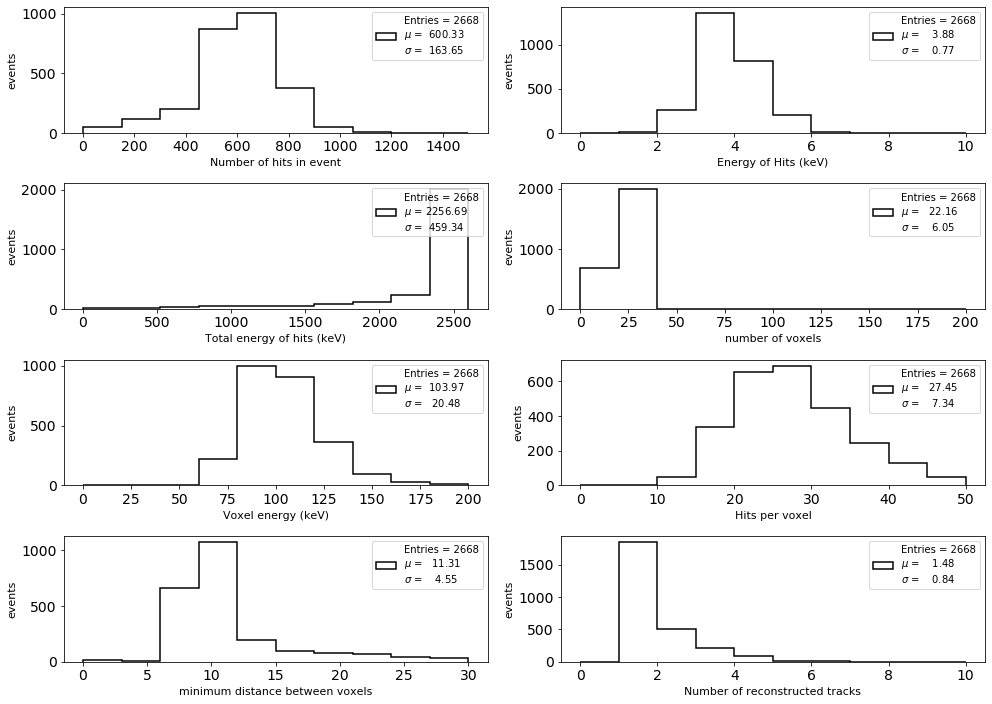

In [853]:
reco_gtrack_stats_histos(rbb.trackRecoStats, 
                         energy_evt_hits = (0,10),  
                         n_voxels        = (0,200),
                         energy_voxels   = (0,200),
                         n_hits_voxels   = (0,50),
                         min_dist_voxels = (0,30),
                         figsize=(14,10))

##### 1e

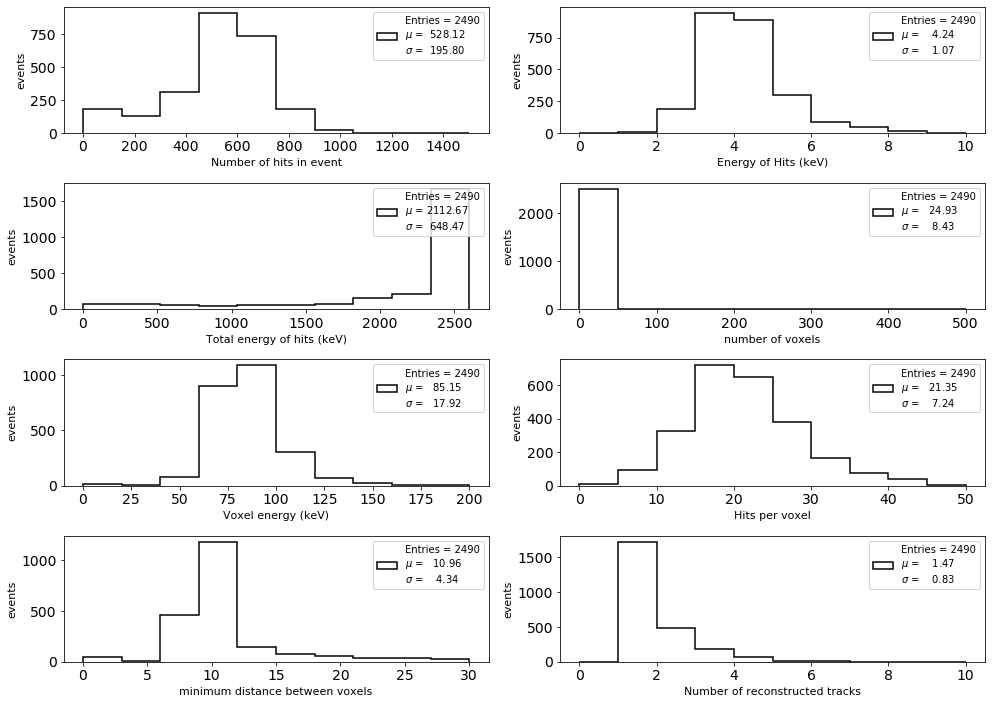

In [854]:
reco_gtrack_stats_histos(r1e.trackRecoStats, 
                         energy_evt_hits = (0,10),  
                         n_voxels        = (0,500),
                         energy_voxels   = (0,200),
                         n_hits_voxels   = (0,50),
                         min_dist_voxels = (0,30),
                         figsize=(14,10))

- Notice that the number of reconstructed tracks in bb0nu and single electrons have the same distributions (in fact all distributions are very similar) which shows that selecting more than one track does not help (increases signal and background in the same proportion)

#### Timing

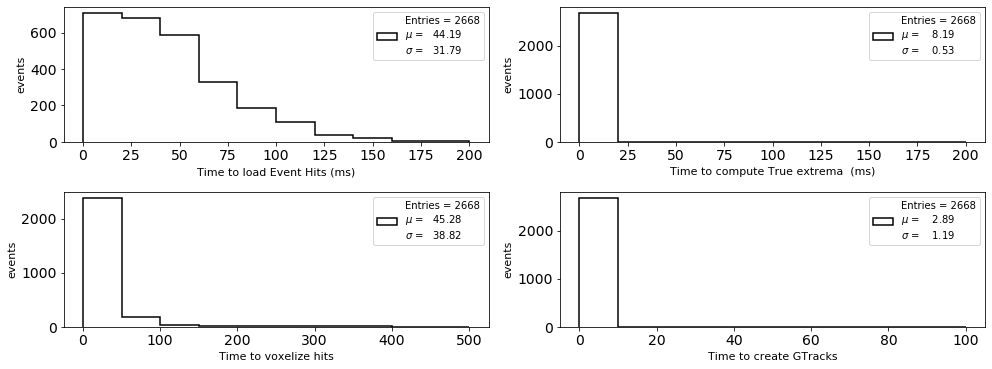

In [855]:
reco_gtrack_timing_histos(rbb.trackRecoTiming, 
                          t_voxelize_hits  = (0,500),
                          t_graph_tracks  = (0,100),
                          figsize=(14,10))

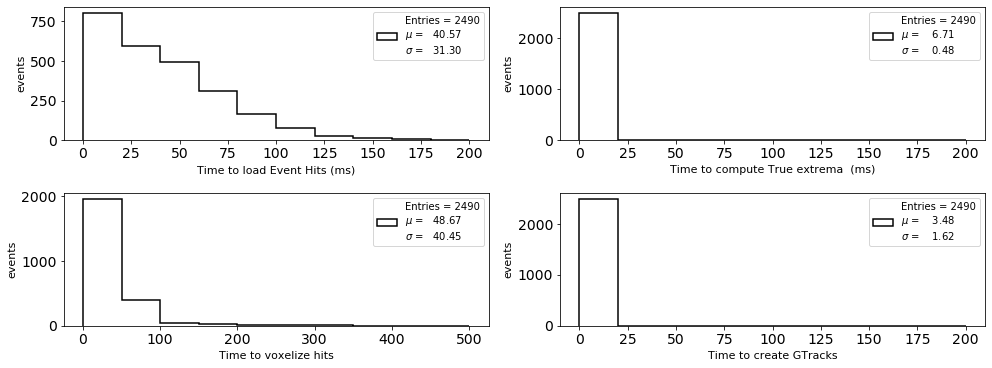

In [856]:
reco_gtrack_timing_histos(r1e.trackRecoTiming, 
                          t_voxelize_hits  = (0,500),
                          figsize=(14,10))

Reconstructing single electrons takes a bit longer (81 ms vs 71 ms) than reconstructing bb0nu which suggests that electron tracks may be a bit longer (less convoluted than bb0nu double electrons)

### Selection on single track and energy 

In [857]:
total_events_bb = rbb.trackRecoEventStats.e_total
total_events_1e = r1e.trackRecoEventStats.e_total

print(f"total events bb = {total_events_bb}")
print(f"total events 1e = {total_events_1e}")

total events bb = 2668
total events 1e = 2492


In [858]:
bad = BAD(total_events_bb, total_events_1e)

#### Single tracks

In [859]:
rbbst = [gt_event for gt_event in rbb.gtracks if len(gt_event) == 1]
r1est = [gt_event for gt_event in r1e.gtracks if len(gt_event) == 1]

In [860]:
st_events_bb = len(rbbst)
st_events_1e = len(r1est)
bad.st_eff_bb    = st_events_bb / total_events_bb
bad.st_eff_1e    = st_events_1e / total_events_1e

print(f" events bb st (single track ) = {st_events_bb}")
print(f" events 1e st                 = {st_events_1e}")
print(f" single track eff bb          = {bad.st_eff_bb}")
print(f" single track eff 1e          = {bad.st_eff_1e}")

 events bb st (single track ) = 1850
 events 1e st                 = 1727
 single track eff bb          = 0.6934032983508246
 single track eff 1e          = 0.6930176565008026


#### Energy cut

In [861]:
bbe = [gt_event[0].voxels_df.energy.sum() / keV for gt_event in rbbst]

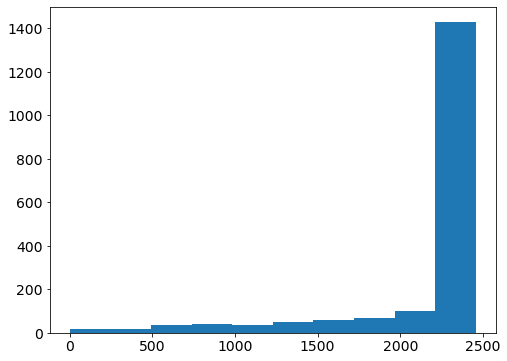

In [862]:
_ = plt.hist(bbe)

In [863]:
e1e = [gt_event[0].voxels_df.energy.sum() / keV for gt_event in r1est]

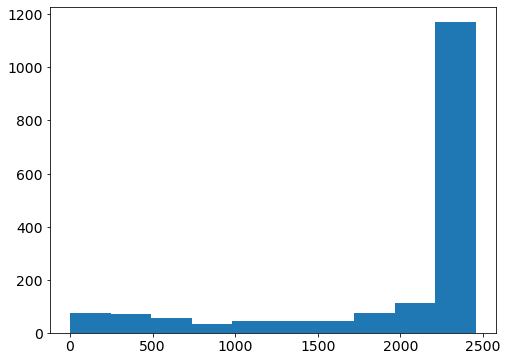

In [864]:
_ = plt.hist(e1e)

In [865]:
rbbe = [gt_event for gt_event in rbbst if in_range(gt_event[0].voxels_df.energy.sum() / keV, 2400, 2500)]

In [866]:
bbe = [gt_event[0].voxels_df.energy.sum() / keV for gt_event in rbbe]

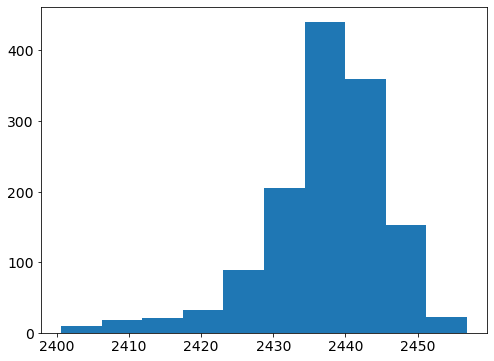

In [867]:
_ = plt.hist(bbe)

In [868]:
re1e = [gt_event for gt_event in r1est if in_range(gt_event[0].voxels_df.energy.sum() / keV, 2400, 2500)]

In [869]:
bbe = [gt_event[0].voxels_df.energy.sum() / keV for gt_event in re1e]

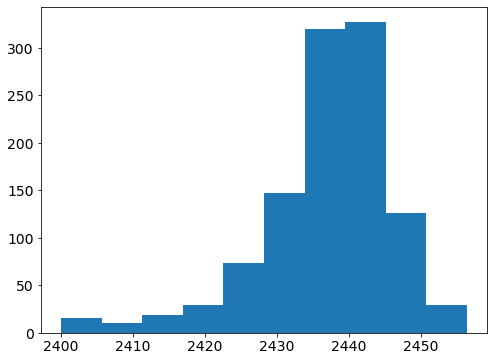

In [870]:
_ = plt.hist(bbe)

In [871]:
bad.energy_eff_bb    = len(rbbe) / len(rbbst)
bad.energy_eff_1e    = len(re1e) / len(r1est)


print(f" single track eff bb          = {bad.st_eff_bb}")
print(f" single track eff 1e          = {bad.st_eff_1e}")
print(f" energy       eff bb          = {bad.energy_eff_bb}")
print(f" energy       eff 1e          = {bad.energy_eff_1e}")

 single track eff bb          = 0.6934032983508246
 single track eff 1e          = 0.6930176565008026
 energy       eff bb          = 0.7297297297297297
 energy       eff 1e          = 0.6346265199768385


### Interactive analysis 

In [872]:
rblobs = np.linspace(2, 30, 15)
rblobs

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
       28., 30.])

event id  = 213, energy = 2439.16 keV

        Reconstructed extrema:
        e1 = (-227.18605105508388, 278.96649979646423, 648.9651126365881) in mm
        e2 = (-232.87556139643544, 271.9954461090925, 709.5493820041671) in mm
        True extrema:
        t1 = [-227.31655884  279.18347168  648.78668213] in mm
        t2 = [-233.38461304  269.77822876  709.34716797] in mm
        Distance true-reco:
        d1 =   0.3     in mm
        d2 =   2.3     in mm
        Energy of the blobs for smaller radius:
        eb1 = 272.1 keV
        eb2 = 1e+02 keV
        Energy of the blobs for larger radius:
        eb1 = 1294.7 keV
        eb2 = 6e+02 keV

        


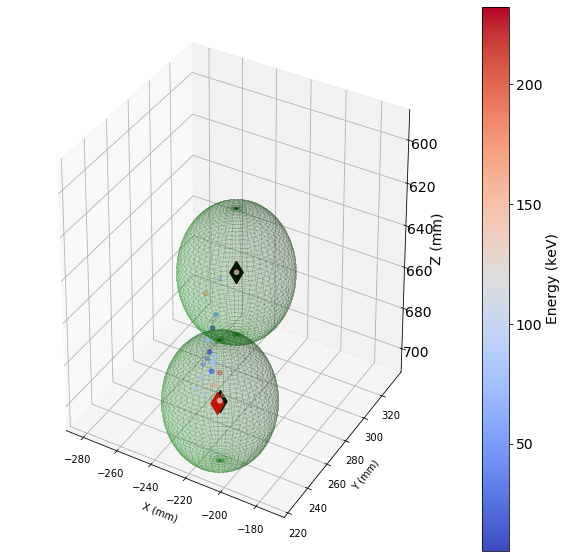

event id  = 214, energy = 2437.59 keV

        Reconstructed extrema:
        e1 = (-140.6580784338441, -67.92191323459953, 102.22400975094409) in mm
        e2 = (-118.36476754567751, -49.609863167452346, 63.07365373326637) in mm
        True extrema:
        t1 = [-140.50587463  -67.94478607  101.53165436] in mm
        t2 = [-115.28289032  -46.68539429   63.92531967] in mm
        Distance true-reco:
        d1 =   0.7     in mm
        d2 =   4.3     in mm
        Energy of the blobs for smaller radius:
        eb1 = 576.8 keV
        eb2 = 1e+02 keV
        Energy of the blobs for larger radius:
        eb1 = 937.1 keV
        eb2 = 3e+02 keV

        


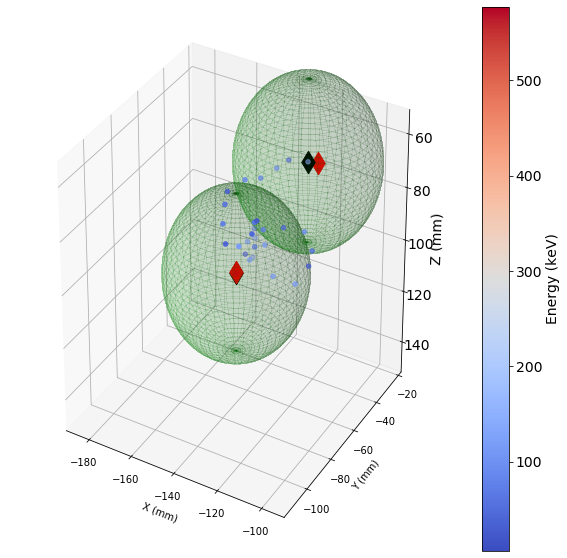

event id  = 215, energy = 2438.89 keV

        Reconstructed extrema:
        e1 = (-332.43997697851444, -319.7753098942638, 1051.7535136828349) in mm
        e2 = (-360.39711642796004, -289.31483370798054, 1076.4110376725657) in mm
        True extrema:
        t1 = [-333.07601929 -321.04690552 1052.43005371] in mm
        t2 = [-351.85073853 -301.66876221 1087.98913574] in mm
        Distance true-reco:
        d1 =   1.6     in mm
        d2 =  19.0     in mm
        Energy of the blobs for smaller radius:
        eb1 = 170.1 keV
        eb2 = 4e+02 keV
        Energy of the blobs for larger radius:
        eb1 = 1068.6 keV
        eb2 = 1e+03 keV

        


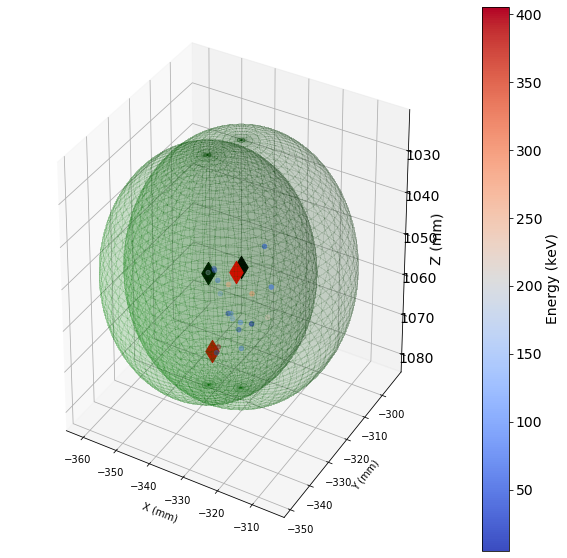

event id  = 172, energy = 2435.03 keV

        Reconstructed extrema:
        e1 = (-215.0409230210671, -343.80560421031413, 531.267340862821) in mm
        e2 = (-191.40942737793696, -330.1217091860779, 555.4453698400929) in mm
        True extrema:
        t1 = [-215.05078125 -343.99438477  530.15179443] in mm
        t2 = [-183.24700928 -327.42150879  563.8392334 ] in mm
        Distance true-reco:
        d1 =   1.1     in mm
        d2 =  12.0     in mm
        Energy of the blobs for smaller radius:
        eb1 = 293.0 keV
        eb2 = 3e+01 keV
        Energy of the blobs for larger radius:
        eb1 = 656.9 keV
        eb2 = 1e+03 keV

        


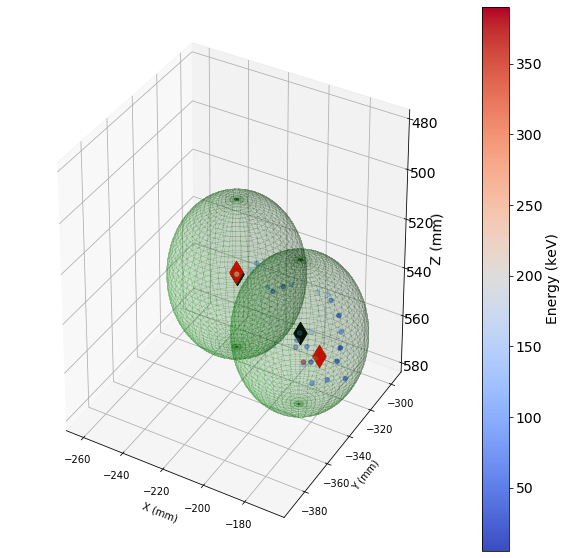

event id  = 173, energy = 2440.79 keV

        Reconstructed extrema:
        e1 = (166.66651588651655, 102.1793224741492, 537.7379748195647) in mm
        e2 = (176.7290112418491, 156.487998608474, 473.3030040116299) in mm
        True extrema:
        t1 = [166.92436218 102.70442963 538.93029785] in mm
        t2 = [177.21934509 158.90208435 474.25280762] in mm
        Distance true-reco:
        d1 =   1.3     in mm
        d2 =   2.6     in mm
        Energy of the blobs for smaller radius:
        eb1 = 288.8 keV
        eb2 = 4e+02 keV
        Energy of the blobs for larger radius:
        eb1 = 792.3 keV
        eb2 = 1e+03 keV

        


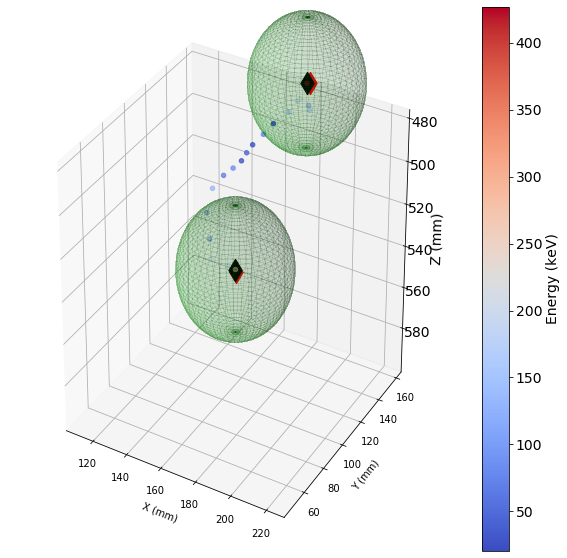

In [873]:
bbdf = single_track_interactive_analysis(rbbe,
                                         rbb.tExtrema,
                                         rb          = rblobs,
                                         events_int  = 5,
                                         figsize     = (10,10),
                                         fontsize    = 10,
                                         rangeshift  = 0.5)

In [874]:
bbdf.head()

event_id       energy    rb         eb1         eb2  \
evt_number rb_number                                                        
0          0               213  2439.155291   2.0  272.138014  117.647201   
           1               213  2439.155291   4.0  272.138014  117.647201   
           2               213  2439.155291   6.0  272.138014  349.851415   
           3               213  2439.155291   8.0  272.138014  349.851415   
           4               213  2439.155291  10.0  454.021648  349.851415   

                            d1        d2  
evt_number rb_number                      
0          0          0.309752  2.283873  
           1          0.309752  2.283873  
           2          0.309752  2.283873  
           3          0.309752  2.283873  
           4          0.309752  2.283873

event id  = 10414, energy = 2442.52 keV

        Reconstructed extrema:
        e1 = (-322.9331359863281, -188.8568878173828, 1066.39404296875) in mm
        e2 = (-313.89835469948, -216.06780120539318, 1073.0690394094665) in mm
        True extrema:
        t1 = [-322.93313599 -188.85688782 1066.39404297] in mm
        t2 = [-312.23828125 -212.36444092 1062.52233887] in mm
        Distance true-reco:
        d1 =   0.0     in mm
        d2 =  11.3     in mm
        Energy of the blobs for smaller radius:
        eb1 =   1.8 keV
        eb2 = 3e+01 keV
        Energy of the blobs for larger radius:
        eb1 = 427.6 keV
        eb2 = 1e+03 keV

        


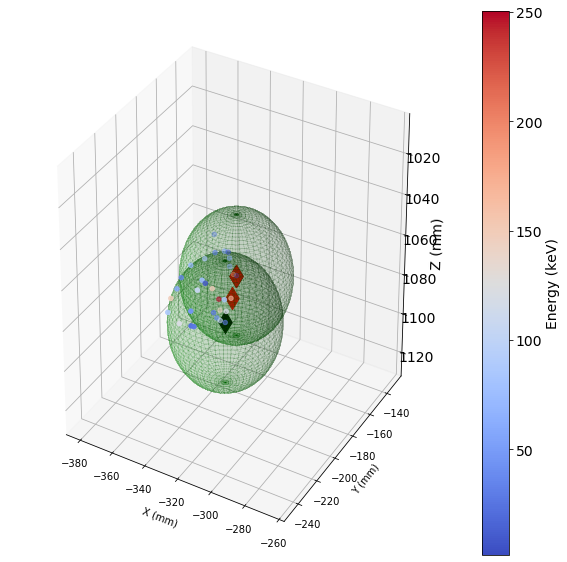

event id  = 1804, energy = 2426.04 keV

        Reconstructed extrema:
        e1 = (-297.60084159924196, 186.8554652702559, 202.56505500203116) in mm
        e2 = (-265.26262423107266, 192.58301880720225, 164.20685678958492) in mm
        True extrema:
        t1 = [-297.05679321  187.52183533  201.39840698] in mm
        t2 = [-262.35733032  169.33782959  177.91455078] in mm
        Distance true-reco:
        d1 =   1.4     in mm
        d2 =  27.1     in mm
        Energy of the blobs for smaller radius:
        eb1 =  35.4 keV
        eb2 = 3e+02 keV
        Energy of the blobs for larger radius:
        eb1 = 354.4 keV
        eb2 = 1e+03 keV

        


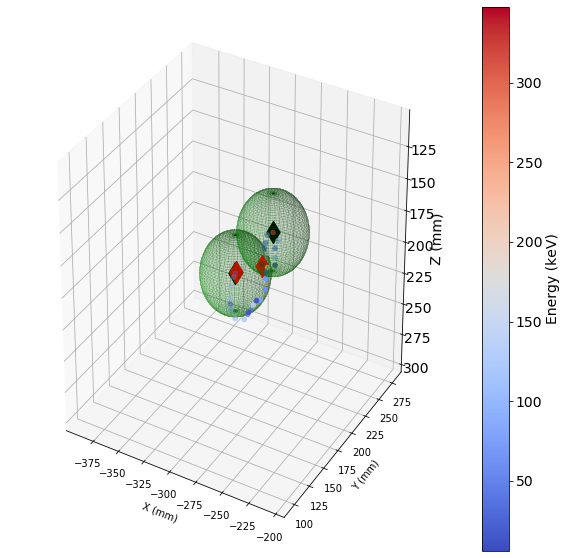

event id  = 1805, energy = 2443.19 keV

        Reconstructed extrema:
        e1 = (-80.94261465960649, 37.899370954971786, 487.2544941361807) in mm
        e2 = (-115.76044887599768, 70.92181359543154, 431.3519508780828) in mm
        True extrema:
        t1 = [-80.57872009  37.60435104 487.94540405] in mm
        t2 = [-75.50740051  40.45306778 447.70611572] in mm
        Distance true-reco:
        d1 =   0.8     in mm
        d2 =  53.1     in mm
        Energy of the blobs for smaller radius:
        eb1 =  26.1 keV
        eb2 = 8e+01 keV
        Energy of the blobs for larger radius:
        eb1 = 857.3 keV
        eb2 = 2e+02 keV

        


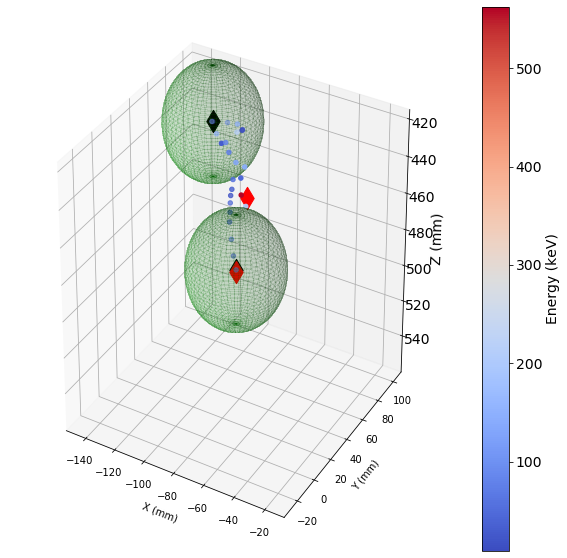

event id  = 5136, energy = 2437.34 keV

        Reconstructed extrema:
        e1 = (-230.89051931801706, 154.16000312849454, 1056.0052973969262) in mm
        e2 = (-326.98338207540087, 160.3597015020646, 996.5632004646535) in mm
        True extrema:
        t1 = [-228.01422119  154.4197998  1060.89599609] in mm
        t2 = [-316.53692627  161.86175537  993.4185791 ] in mm
        Distance true-reco:
        d1 =   5.7     in mm
        d2 =  11.0     in mm
        Energy of the blobs for smaller radius:
        eb1 = 123.5 keV
        eb2 = 8e+01 keV
        Energy of the blobs for larger radius:
        eb1 = 1318.6 keV
        eb2 = 3e+02 keV

        


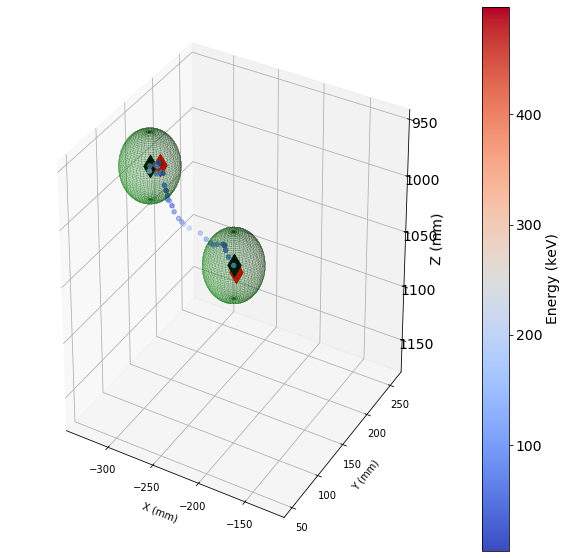

event id  = 5139, energy = 2422.55 keV

        Reconstructed extrema:
        e1 = (378.98858760802113, 229.8828611088146, 363.62878985643215) in mm
        e2 = (360.97331603457457, 250.87293912958916, 308.16249185705584) in mm
        True extrema:
        t1 = [383.01248169 228.74699402 361.91220093] in mm
        t2 = [358.72723389 248.30792236 307.19277954] in mm
        Distance true-reco:
        d1 =   4.5     in mm
        d2 =   3.5     in mm
        Energy of the blobs for smaller radius:
        eb1 = 371.8 keV
        eb2 = 8e+01 keV
        Energy of the blobs for larger radius:
        eb1 = 792.7 keV
        eb2 = 4e+02 keV

        


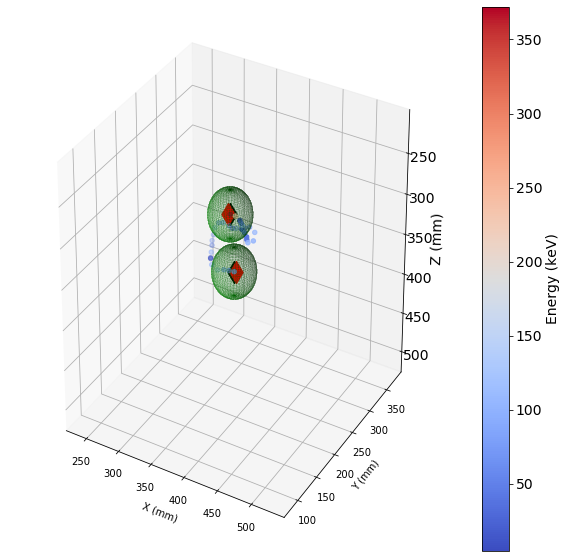

In [875]:
e1df = single_track_interactive_analysis(re1e,
                                         r1e.tExtrema,
                                         rb          = rblobs,
                                         events_int  = 5,
                                         figsize     = (10,10),
                                         fontsize    = 10,
                                         rangeshift  = 0.75)

In [876]:
e1df.head()

event_id       energy    rb         eb1         eb2  \
evt_number rb_number                                                        
0          0             10414  2442.524646   2.0    1.794617   31.198502   
           1             10414  2442.524646   4.0  177.873697   31.198502   
           2             10414  2442.524646   6.0  177.873697  132.471755   
           3             10414  2442.524646   8.0  231.413394  314.612437   
           4             10414  2442.524646  10.0  231.413394  314.612437   

                       d1         d2  
evt_number rb_number                  
0          0          0.0  11.300602  
           1          0.0  11.300602  
           2          0.0  11.300602  
           3          0.0  11.300602  
           4          0.0  11.300602

### Selecting blobs

#### rb = 4

In [945]:
bbr4 = bbdf[bbdf.rb==6]
e1r4 = e1df[e1df.rb==6]

In [946]:
bbr4.head()

,,event_id,energy,rb,eb1,eb2,d1,d2
evt_number,rb_number,,,,,,,
0,2,213,2439.155291,6.0,272.138014,349.851415,0.309752,2.283873
1,2,214,2437.588026,6.0,576.817393,146.228358,0.709257,4.333107
2,2,215,2438.890995,6.0,254.031800,387.142351,1.574551,18.966088
3,2,172,2435.026454,6.0,293.046087,163.333865,1.131450,12.015536
4,2,173,2440.788653,6.0,462.036803,426.416904,1.328103,2.640145


In [947]:
e1r4.head()

,,event_id,energy,rb,eb1,eb2,d1,d2
evt_number,rb_number,,,,,,,
0,2,10414,2442.524646,6.0,177.873697,132.471755,0.000000,11.300602
1,2,1804,2426.043870,6.0,101.292945,323.885322,1.449519,27.141858
2,2,1805,2443.186398,6.0,179.781456,81.807368,0.834753,53.067043
3,2,5136,2437.338658,6.0,182.355911,79.194508,5.679746,11.012413
4,2,5139,2422.554663,6.0,371.794373,77.516504,4.519800,3.544649


(array([867., 177., 128.,  73.,  48.,  25.,  21.,   6.,   3.,   2.]),
 array([3.94091198e-03, 6.02780937e+00, 1.20516778e+01, 1.80755463e+01,
        2.40994147e+01, 3.01232832e+01, 3.61471516e+01, 4.21710201e+01,
        4.81948885e+01, 5.42187570e+01, 6.02426254e+01]),
 <a list of 10 Patch objects>)

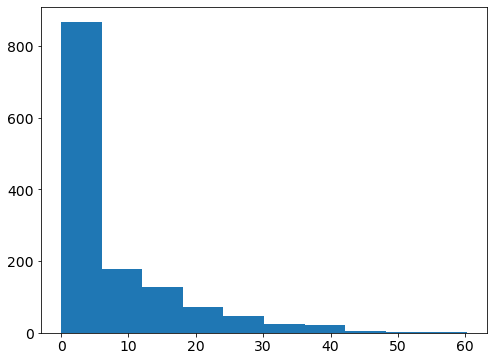

In [948]:
plt.hist(bbr4.d1)

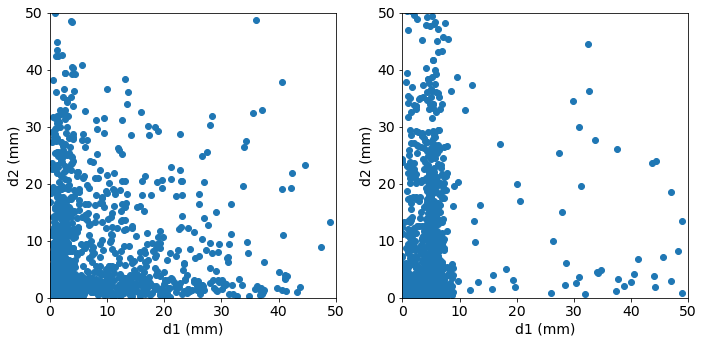

In [949]:
draw_blobs_distances(bbr4, e1r4, figsize=(10,5))

In [950]:
emin, emax = emin_emax(bbr4, e1r4, minval=10)

In [951]:
print(emin, emax)

8.749919012188911 700.4261911846697


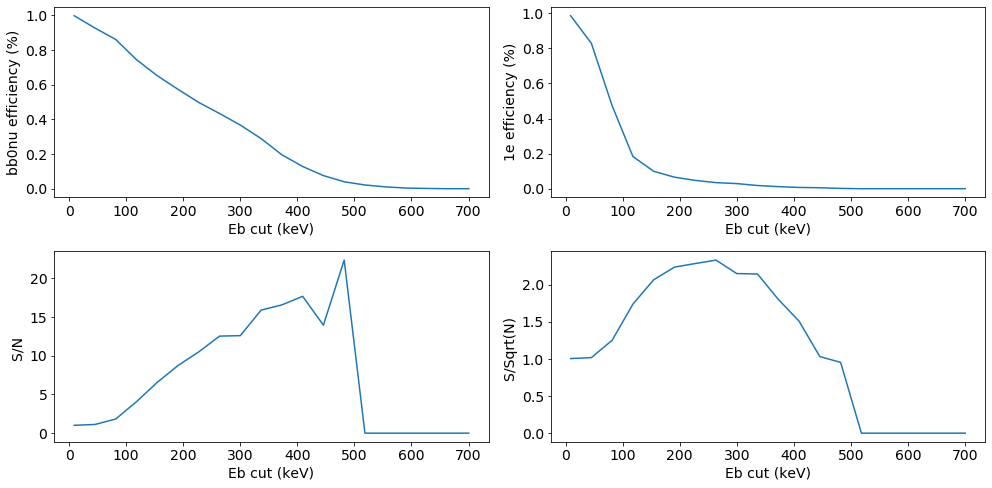

In [952]:
ebcut, eBB, e1E, fm1, fm2 = blobs_figure_of_merit(bbr4, e1r4, eb_range = (emin,emax), npoints=20,
                                           plotting = True, figsize=(14,7))

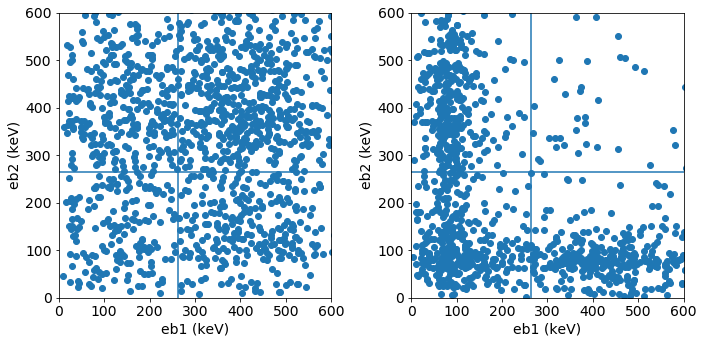

In [953]:
draw_blobs_energy(bbr4, e1r4, eb_cut=ebcut[np.argmax(fm2)], eb_range=(0,600), figsize=(10,5))

In [954]:
bad.blobs_eff_bb,  bad.blobs_eff_1e, bad.bb_1e_rf, bad.bb_1e_fm   = blob_selection_efficiency(bbr4, e1r4, eb_cut=ebcut[np.argmax(fm2)])

In [955]:
bad


        single track eff 1e          =  0.69
        energy       eff bb          =  0.73
        energy       eff 1e          =  0.63
        blobs        eff bb          =  0.43
        blobs        eff 1e          = 0.035
        blobs suppresion factor      = 12.52
        blobs figure of merit        =  2.33
        

#### R = 10 mm

In [887]:
bbr10 = bbdf[bbdf.rb==10]
e1r10 = e1df[e1df.rb==10]

22.00940251350403 871.1464285850525


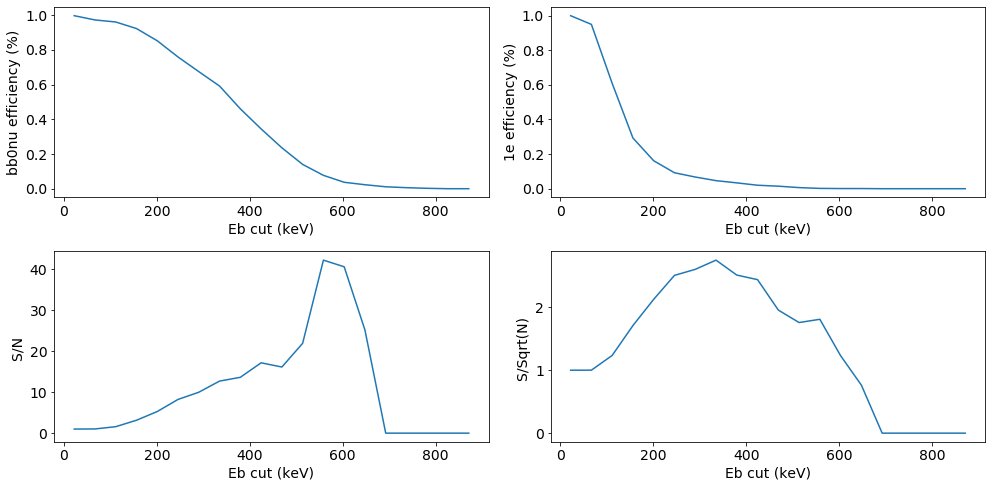

In [888]:
emin, emax = emin_emax(bbr10, e1r10)
print(emin, emax)
ebcut, eBB, e1E, fm1, fm2 = blobs_figure_of_merit(bbr10, e1r10, eb_range = (emin,emax), npoints=20,
                                           plotting = True, figsize=(14,7))

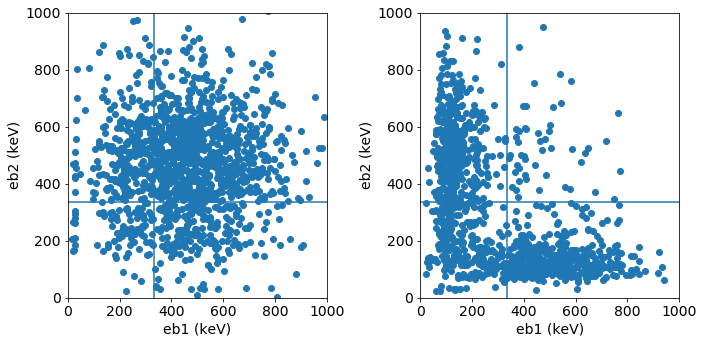

In [889]:
draw_blobs_energy(bbr10, e1r10, eb_cut=ebcut[np.argmax(fm2)], eb_range=(0,1000), figsize=(10,5))

In [890]:
bad.blobs_eff_bb,  bad.blobs_eff_1e, bad.bb_1e_rf, bad.bb_1e_fm   = blob_selection_efficiency(bbr10, e1r10, eb_cut=ebcut[np.argmax(fm2)])

In [891]:
bad


        single track eff 1e          =  0.69
        energy       eff bb          =  0.73
        energy       eff 1e          =  0.63
        blobs        eff bb          =  0.59
        blobs        eff 1e          = 0.047
        blobs suppresion factor      = 12.70
        blobs figure of merit        =  2.74
        

#### r = 20

In [892]:
bbr20 = bbdf[bbdf.rb==20]
e1r20 = e1df[e1df.rb==20]

44.91453245282173 1158.7447897531092


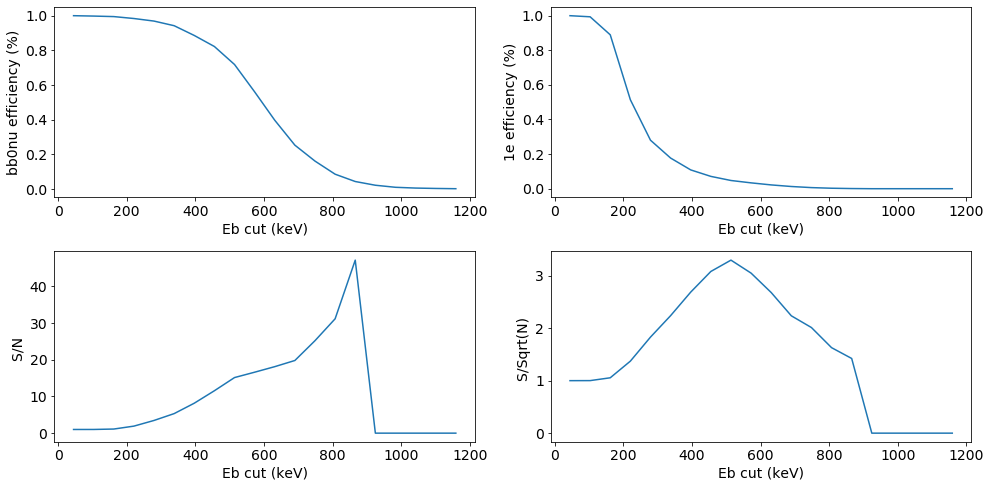

In [912]:
emin, emax = emin_emax(bbr20, e1r20)
print(emin, emax)
ebcut, eBB, e1E, fm1, fm2 = blobs_figure_of_merit(bbr20, e1r20, eb_range = (emin,emax), npoints=20,
                                           plotting = True, figsize=(14,7))

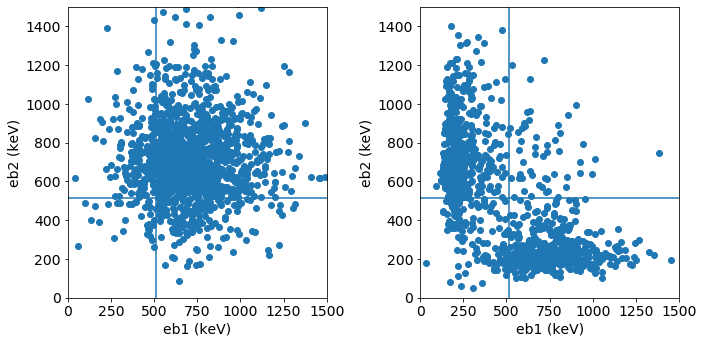

In [894]:
draw_blobs_energy(bbr20, e1r20, eb_cut=ebcut[np.argmax(fm2)], eb_range=(0,1500), figsize=(10,5))

In [895]:
bad.blobs_eff_bb,  bad.blobs_eff_1e, bad.bb_1e_rf, bad.bb_1e_fm   = blob_selection_efficiency(bbr20, e1r20, eb_cut=ebcut[np.argmax(fm2)])

In [896]:
bad


        single track eff 1e          =  0.69
        energy       eff bb          =  0.73
        energy       eff 1e          =  0.63
        blobs        eff bb          =  0.72
        blobs        eff 1e          = 0.047
        blobs suppresion factor      = 15.13
        blobs figure of merit        =  3.30
        

#### R = 24 mm

In [926]:
bbr24 = bbdf[bbdf.rb==24]
e1r24 = e1df[e1df.rb==24]

257.54813719540834 1341.853236220777


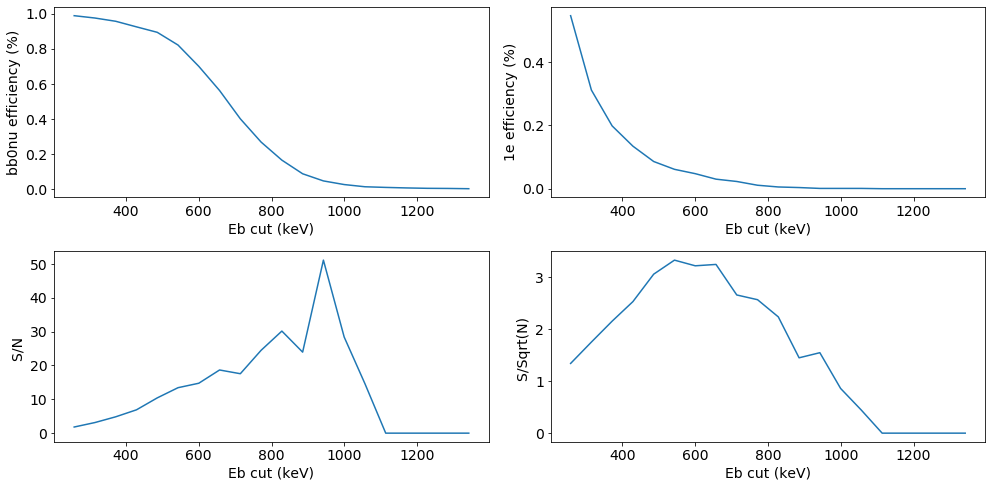

In [931]:
emin, emax = emin_emax(bbr24, e1r24, minval=10)
print(emin, emax)
ebcut, eBB, e1E, fm1, fm2 = blobs_figure_of_merit(bbr24, e1r24, eb_range = (emin,emax), npoints=20,
                                           plotting = True, figsize=(14,7))

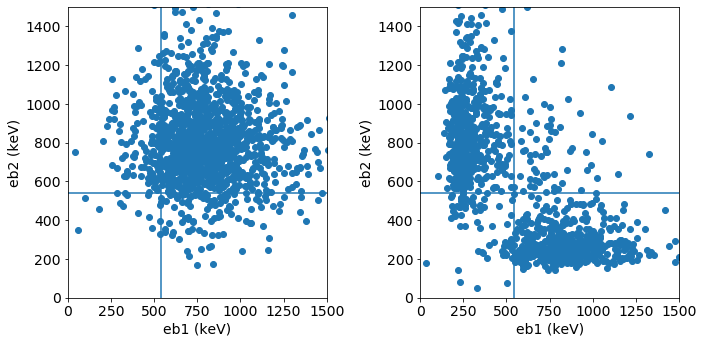

In [932]:
draw_blobs_energy(bbr24, e1r24, eb_cut=ebcut[np.argmax(fm2)], eb_range=(0,1500), figsize=(10,5))

In [943]:
bad.blobs_eff_bb,  bad.blobs_eff_1e, bad.bb_1e_rf, bad.bb_1e_fm   = blob_selection_efficiency(bbr20, e1r20, eb_cut=ebcut[np.argmax(fm2)])
bad


        single track eff 1e          =  0.69
        energy       eff bb          =  0.73
        energy       eff 1e          =  0.63
        blobs        eff bb          =  0.68
        blobs        eff 1e          = 0.043
        blobs suppresion factor      = 15.96
        blobs figure of merit        =  3.31
        

#### R = 30

In [934]:
bbr30 = bbdf[bbdf.rb==30]
e1r30 = e1df[e1df.rb==30]

246.32154405117035 1597.0280287787318


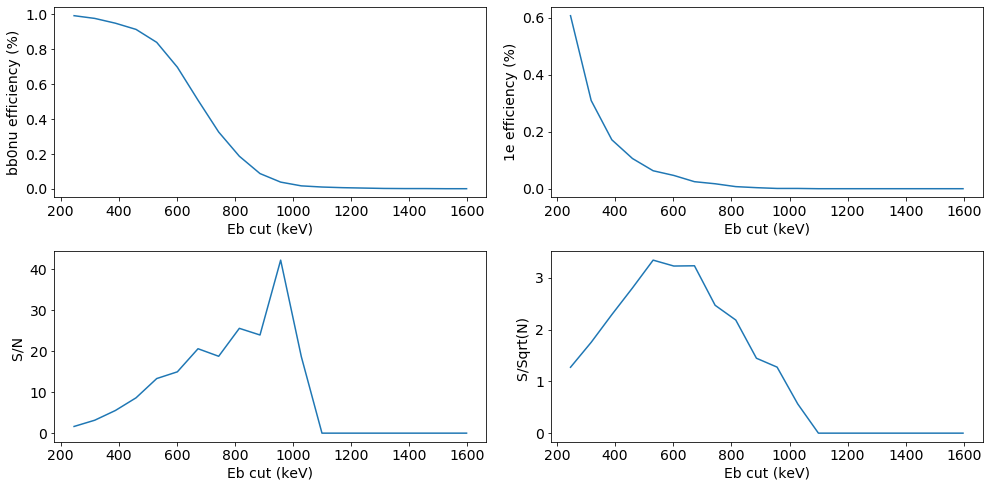

In [935]:
emin, emax = emin_emax(bbr30, e1r30)
print(emin, emax)
ebcut, eBB, e1E, fm1, fm2 = blobs_figure_of_merit(bbr24, e1r24, eb_range = (emin,emax), npoints=20,
                                           plotting = True, figsize=(14,7))

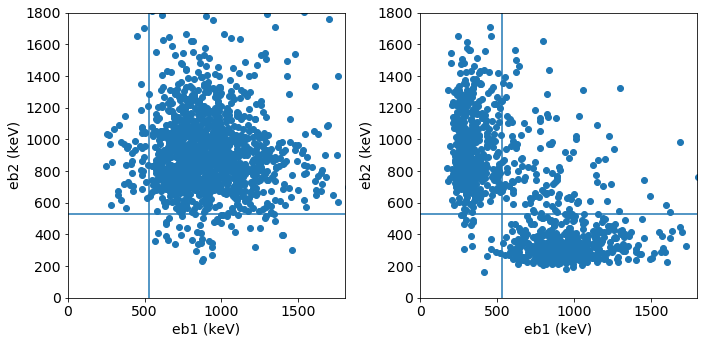

In [936]:
draw_blobs_energy(bbr30, e1r30, eb_cut=ebcut[np.argmax(fm2)], eb_range=(0,1800), figsize=(10,5))

In [942]:
bad.blobs_eff_bb,  bad.blobs_eff_1e, bad.bb_1e_rf, bad.bb_1e_fm   = blob_selection_efficiency(bbr30, e1r30, eb_cut=ebcut[np.argmax(fm2)])
bad


        single track eff 1e          =  0.69
        energy       eff bb          =  0.73
        energy       eff 1e          =  0.63
        blobs        eff bb          =  0.93
        blobs        eff 1e          = 0.123
        blobs suppresion factor      =  7.51
        blobs figure of merit        =  2.64
        

#### Study blob radius

In [938]:
rblobs 

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
       28., 30.])

In [939]:
rbl = np.delete(rblobs, 2)

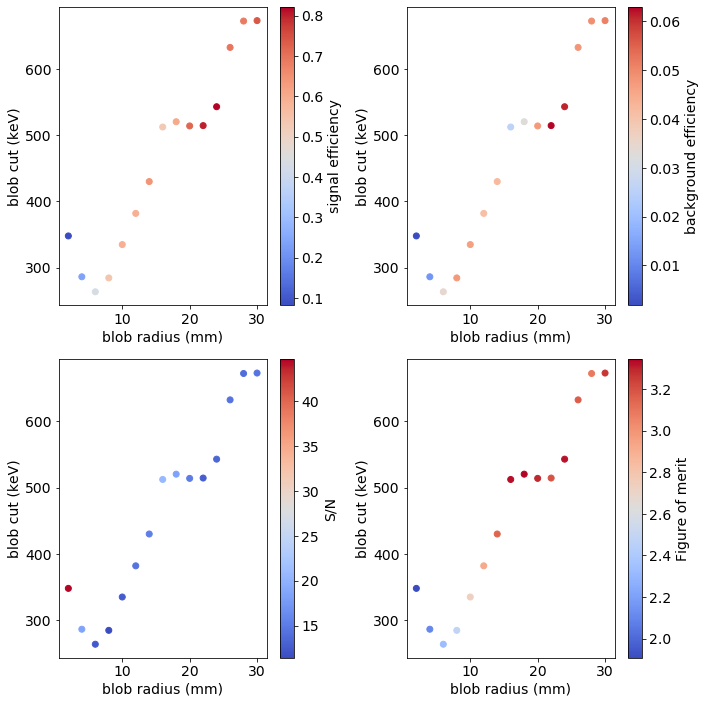

In [940]:
plot_figures_of_merit(bbdf, e1df, rblobs)